In [2]:
import sqlite3
import csv
import sys

#creating theschool.db
conn = sqlite3.connect('theschool.db')
cursor = conn.cursor()

#enable foreign keys
cursor.execute("PRAGMA foreign_keys = ON")

#drop the table if there is an existing table
cursor.execute("DROP TABLE IF EXISTS ENROLLMENT")
cursor.execute("DROP TABLE IF EXISTS COURSESECTION")
cursor.execute("DROP TABLE IF EXISTS STUDENT")
cursor.execute("DROP TABLE IF EXISTS PROFESSOR")
cursor.execute("DROP TABLE IF EXISTS COURSE")
cursor.execute("DROP TABLE IF EXISTS DEPARTMENT")

#create the DEPARTMENT table
query2 = """CREATE TABLE DEPARTMENT(
  DEPTCODE varchar(5) PRIMARY KEY NOT NULL,
  DEPTDESC varchar(25)
)"""
cursor.execute(query2)

#create the COURSE table
query3 = """CREATE TABLE COURSE(
  CCODE varchar(8) PRIMARY KEY NOT NULL,
  CDESC varchar(50),
  UNITS INTEGER,
  DEPTCODE varchar(5),
  FOREIGN KEY (DEPTCODE) REFERENCES DEPARTMENT(DEPTCODE)
)"""
cursor.execute(query3)

#create the PROFESSOR table
query4 = """CREATE TABLE PROFESSOR(
  EMPID varchar(6) PRIMARY KEY NOT NULL,
  TITLE varchar(8),
  FNAME varchar(25),
  LNAME varchar(25),
  DEPTCODE varchar(5),
  EMAIL varchar(50),
  PHONE varchar(15),
  FOREIGN KEY (DEPTCODE) REFERENCES DEPARTMENT(DEPTCODE)
)"""
cursor.execute(query4)

#create the STUDENT table
query1 = """CREATE TABLE STUDENT(
  STUDNUM varchar(9) PRIMARY KEY NOT NULL,
  FNAME varchar(25),
  LNAME varchar(25),
  DOB date,
  PROG varchar(10),
  EMAIL varchar(50),
  PHONE varchar(11),
  UNITSCAP INTEGER,
  UNITSENROLL INTEGER,
  ENROLLSTAT varchar(10) NOT NULL CHECK (ENROLLSTAT IN ('PENDING','ACTIVE','FINALIZED')) DEFAULT 'PENDING'
)"""
cursor.execute(query1)

#create the COURSESECTION table
query5 = """CREATE TABLE COURSESECTION(
  SECTID varchar(15) PRIMARY KEY NOT NULL,
  CCODE varchar(8),
  PROFID varchar(6),
  SCHEDDAY varchar(8),
  SCHEDTIME varchar(12),
  STUDCAP INTEGER,
  FOREIGN KEY (CCODE) REFERENCES COURSE(CCODE),
  FOREIGN KEY (PROFID) REFERENCES PROFESSOR(EMPID)
)"""
cursor.execute(query5)

#create the ENROLLMENT table
query6 = """CREATE TABLE ENROLLMENT(
  ID INTEGER PRIMARY KEY AUTOINCREMENT,
  STUDNUM varchar(9),
  CCODE varchar(8),
  EMPID varchar(6),
  DEPTCODE varchar(5),
  SECTID varchar(15),
  FOREIGN KEY (STUDNUM) REFERENCES STUDENT(STUDNUM),
  FOREIGN KEY (CCODE) REFERENCES COURSE(CCODE),
  FOREIGN KEY (EMPID) REFERENCES PROFESSOR(EMPID),
  FOREIGN KEY (DEPTCODE) REFERENCES DEPARTMENT(DEPTCODE),
  FOREIGN KEY (SECTID) REFERENCES COURSESECTION(SECTID)
)"""
cursor.execute(query6)

#get seed data from csv
csv_files =[ ('DEPARTMENT.csv',"INSERT INTO DEPARTMENT (DEPTCODE, DEPTDESC) VALUES(?, ?)"),
 ('COURSE.csv',"INSERT INTO COURSE (CCODE, CDESC, UNITS, DEPTCODE) VALUES(?, ?, ?, ?)"),
 ('PROFESSOR.csv',"INSERT INTO PROFESSOR (EMPID, TITLE, FNAME, LNAME, DEPTCODE, EMAIL, PHONE) VALUES(?, ?, ?, ?, ?, ?, ?)"),
 ('STUDENT.csv',"INSERT INTO STUDENT (STUDNUM, FNAME, LNAME, DOB, PROG, EMAIL, PHONE, UNITSCAP, ENROLLSTAT) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)"),
 ('COURSESECTION.csv',"INSERT INTO COURSESECTION (SECTID, CCODE, PROFID, SCHEDDAY, SCHEDTIME, STUDCAP) VALUES(?, ?, ?, ?, ?, ?)"),
 ('enrollment_data_2025REV.csv',"INSERT INTO ENROLLMENT (STUDNUM, CCODE, EMPID, DEPTCODE, SECTID) VALUES(?, ?, ?, ?, ?)")
]

for filename,insert_query in csv_files:
  with open(filename, newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    cursor.executemany(insert_query, reader)

#commit changes
conn.commit()

#close connection
conn.close()


In [3]:
import sqlite3
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

#this class is for creating a students account in the enrollment system
class Student():
    def __init__(self, studnum, fname, lname, dob, prog, phone):
        #these are the information we would be asking from the student
        self.__studnum = studnum
        self.__fname = fname
        self.__lname = lname
        self.__dob = dob
        self.__prog = prog
        self.__phone = phone

        #autogenerated email
        self.__email = self.generate_email()

        #default status is pending because admin still has to put things in
        self.__enstat = "PENDING"

        #these are the information we would be getting from the admin
        self.__uncap = None #units capacity/maximum units
    
    #helper functions
    def generate_email(self):
        return f"{self.getfname().lower()}.{self.getlname().lower()}@theschool.edu.ph"

    #calculate units enrolled
    def calcunen(self, enrollment_data):
        if not enrollment_data:
            return 0
        return sum( course['units'] for course in enrollment_data if course.get('studnum') == self.getstudnum())
    
    #a function that checks for duplicates for student number
    @staticmethod
    def checkdupes(studnum):
        conn = sqlite3.connect('theschool.db')
        cursor = conn.cursor()
        cursor.execute("SELECT STUDNUM FROM student WHERE STUDNUM = ?",(studnum,))
        result = cursor.fetchone()
        conn.close()
        return result is not None

    #getters
    def getstudnum(self): return self.__studnum
    def getfname(self): return self.__fname
    def getlname(self): return self.__lname
    def getdob(self): return self.__dob
    def getprog(self): return self.__prog
    def getemail(self): return self.__email
    def getphone(self): return self.__phone
    def getunen(self, enrollment_data): return self.calcunen(enrollment_data)
    def getuncap(self): return self.__uncap
    def getstat(self): return self.__enstat

    #setters
    def setstudnum(self, studnum): self.__studnum = studnum
    def setfname(self, fname): self.__fname = fname
    def setlname(self, lname): self.__lname = lname
    def setdob(self, dob): self.__dob = dob
    def setprog(self, prog): self.__prog = prog
    def setphone(self, phone): self.__phone = phone
    def setuncap(self, uncap): self.__uncap = uncap
    def setstat(self, enstat): self.__enstat = enstat

    #outputs info into a dict that can be loaded to the Student table
    def todict(self, enrollment_data):
        return {
            'STUDNUM': self.getstudnum(),
            'FNAME': self.getfname(),
            'LNAME': self.getlname(),
            'PROG': self.getprog(),
            'DOB': self.getdob(),
            'EMAIL': self.getemail(),
            'PHONE': self.getphone(),
            'UNITSCAP': self.getuncap(),
            'UNITSENROLL': self.getunen(enrollment_data),
            'ENROLLSTAT': self.getstat()
        }

    #puts the data into the table
    def insertnewstd(self, data_dict):
        conn = sqlite3.connect('theschool.db')
        cursor = conn.cursor()
        
        try:
            query = ('INSERT INTO student (STUDNUM, FNAME, LNAME, DOB, PROG, EMAIL, PHONE, UNITSCAP, UNITSENROLL, ENROLLSTAT)'
                     'VALUES ( ?, ?, ?, ?, ?, ?, ?, ?, ?, ?);')
            cursor.execute(query, tuple(data_dict.values()))
            conn.commit()
            return "Account created successfully!"
        
        except sqlite3.Error as e:
            conn.rollback()
            return f"Failed to add student: {e}"
        
        except Exception as e:
            conn.rollback()
            return f"An error occurred: {e}"
        
        finally:
            conn.close()

#this class is for the Enrollment System
class EnrollmentSystem:
    def __init__(self, db_name="theschool.db"):
        self.db_name = db_name

    #this happens a lot so let's put it in a method
    def connect_db(self):
      return sqlite3.connect(self.db_name)

    def is_enrolled(self, studnum, ccode):
      conn = self.connect_db()
      cursor = conn.cursor()
            
      #the query we will use to check if they already have a specific course
      query = """
        SELECT 1 FROM enrollment
        WHERE studnum = ? AND ccode = ?
      """
            
      cursor.execute(query, (studnum, ccode))
      result = cursor.fetchone()
      conn.close()
      return result is not None

    def get_enroll_stat(self, studnum):
      try:
          conn = self.connect_db()
          cursor = conn.cursor()
          cursor.execute("SELECT ENROLLSTAT FROM student WHERE STUDNUM = ?", (studnum,))
          result = cursor.fetchone()
          if result:
              return result[0]
          else:
              print(f"No student found with Student Number: {studnum}")
              return None
      except sqlite3.Error as e:
          print(f"Database error: {e}")
          return None

    def get_total_units(self, studnum):
      conn = self.connect_db()
      cursor = conn.cursor()

      #the query we will use to get the total units a student already has
      query = """
        SELECT SUM(c.units)
        FROM enrollment e
        JOIN coursesection cs on e.SECTID = cs.SECTID
        JOIN course c on cs.CCODE = c.CCODE
        WHERE e.studnum = ?
        """

      cursor.execute(query, (studnum,))
      total_units = cursor.fetchone()[0] or 0
      conn.close()
      return total_units
    
    def get_unit_cap(self, studnum):
      conn = self.connect_db()
      cursor = conn.cursor()

      #the query is short so we directly put it in execute
      cursor.execute("SELECT UNITSCAP FROM student WHERE studnum = ?", (studnum,))
      result = cursor.fetchone()
      conn.close()
      return result[0] if result else 0

    def is_section_full(self, SECTID):
      conn = self.connect_db()
      cursor = conn.cursor()

      #the query we will use to get course capacity
      query = """
        SELECT cs.STUDCAP, COUNT(e.studnum)
        FROM coursesection cs
        LEFT JOIN enrollment e ON  cs.SECTID = e.SECTID
        WHERE cs.SECTID = ?
        GROUP BY cs.STUDCAP
        """
            
      cursor.execute(query, (SECTID,))
      result = cursor.fetchone()
      conn.close()
      if not result:
        return False
      cap, enrolled = result
      return enrolled >= cap

    def enroll_student(self, studnum, sectid):
      conn = self.connect_db()
      cursor = conn.cursor()

      #get section ccode
      cursor.execute("SELECT CCODE FROM coursesection WHERE SECTID = ?", (sectid,))
      cresult = cursor.fetchone()
      if not cresult:
        return "Invalid section."
      coursecode = cresult[0]

      #check if already enrolled
      if self.is_enrolled(studnum, coursecode):
        return "You are already enrolled in this course."

      #check if units has reached max
      total_units = self.get_total_units(studnum)
      cursor.execute("SELECT UNITS FROM course WHERE CCODE = ?",(coursecode,))
      course_units = cursor.fetchone()[0]
      unit_cap = self.get_unit_cap(studnum)
      if total_units + course_units > unit_cap:
        return f"Cannot enroll: Total units would exceed your maximum unit of {unit_cap}."

      #check if section is full
      if self.is_section_full(sectid):
        return "This section is already full."

      #if OK on all checks
      try:
        cursor.execute("INSERT INTO enrollment (STUDNUM, SECTID, CCODE) VALUES (?,?,?)", (studnum, sectid, coursecode))
        conn.commit()
        return "Enrollment successful!"
            
      except sqlite3.Error as e:
        conn.rollback()
        return f"Failed to enroll: {e}"
      
      finally:
        conn.close()
    
    def remove_enroll(self, studnum, secid):
      conn = self.connect_db()
      cursor = conn.cursor()
      try:
        #is the student in the section?
        cursor.execute("SELECT CCODE FROM enrollment WHERE STUDNUM = ? AND SECTID = ?", (studnum, secid))
        result = cursor.fetchone()
        if not result:
          return "Student is not enrolled in that section."
          
        courseid = result[0]

        #how many units to subtract?
        cursor.execute("SELECT UNITS FROM course WHERE CCODE = ?", (courseid,))
        units = cursor.fetchone()[0]

        #delete enrollment then update units
        cursor.execute("DELETE FROM enrollment WHERE STUDNUM = ? AND SECTID = ?", (studnum, secid))
        cursor.execute("UPDATE student SET UNITSENROLL = UNITSENROLL - ? WHERE STUDNUM = ?", (units, studnum))
        conn.commit()
        return "Enrollment removed successfully!"

      except Exception as e:
        conn.rollback()
        return f"Error removing course: {e}"

    def finalize_student(self, studnum):
      conn = self.connect_db()
      cursor = conn.cursor()
      try:
        cursor.execute("UPDATE student SET ENROLLSTAT = 'FINALIZED' WHERE STUDNUM = ?", (studnum,))
        conn.commit()
        return "Enrollment Finalized!"

      except Exception as e:
        conn.rollback()
        return f"Error Finalizing: {e}"

    def get_timetable(self, studnum):
      conn = self.connect_db()
      cursor = conn.cursor()
      try:
        cursor.execute("""
             SELECT c.CCODE, c.CDESC, cs.SECTID, cs.SCHEDDAY, cs.SCHEDTIME
             FROM enrollment e
             JOIN coursesection cs ON e.SECTID = cs.SECTID
             JOIN course c ON cs.CCODE = c.CCODE
             WHERE e.STUDNUM = ?
        """, (studnum,))
        rows = cursor.fetchall()
        if not rows:
           return "No courses enrolled."

        output = "Your timetable:\n"
        for row in rows:
          output += f"{row[0]}: {row[1]} | Section: {row[2]} | {row[3]} {row[4]}\n"
        return output

      except Exception as e:
        return f"Error getting timetable: {e}"

    def __del__(self):
        if hasattr(self, 'conn'):
            self.conn.close()


#this class is for Admin System
class AdminSystem:
  def __init__(self, db_name="theschool.db"):
    self.db_name = db_name
    
  def connect_db(self):
    return sqlite3.connect(self.db_name)

  #this is where the admin puts in unitscap then the enstat goes from pending to active
  def set_unit_cap(self, studnum, cap):
    conn = self.connect_db()
    cursor = conn.cursor()

    cursor.execute("UPDATE student SET UNITSCAP = ?, ENROLLSTAT = 'ACTIVE' WHERE STUDNUM =?", (cap, studnum))
    conn.commit()
    conn.close()
    return f"Unit cap set for {studnum}, enrollment status changed to 'ACTIVE'."

  #this is to get the prof roster
  def get_prof_roster(self):
    conn = self.connect_db()
    cursor = conn.cursor()

    query = """
      SELECT p.TITLE||' '||p.FNAME||' '||p.LNAME as PROFNAME, c.CCODE, c.CDESC, s.STUDNUM, s.FNAME||' '||s.LNAME AS STUDENTNAME
      FROM professor p
      JOIN coursesection cs ON p.EMPID = cs.PROFID
      JOIN course c ON cs.CCODE = c.CCODE
      LEFT JOIN enrollment e ON cs.SECTID = e.SECTID
      LEFT JOIN student s ON e.STUDNUM = s.STUDNUM
      ORDER BY p.LNAME, c.CCODE, s.LNAME
    """

    cursor.execute(query)
    results = cursor.fetchall()
    conn.close()

    roster ={}
    for PROFNAME, CCODE, CDESC, STUDNUM, STUDENTNAME in results:
      key = (PROFNAME, CCODE, CDESC)
      if key not in roster:
        roster[key] = []
      if STUDNUM:
        roster[key].append(f"{STUDNUM} - {STUDENTNAME}")
      else:
        roster[key].append("No Students Enrolled")
    
    for (PROFNAME, CCODE, CDESC), students in roster.items():
      print(f"\nPROF: {PROFNAME}\nCOURSE: {CCODE} - {CDESC}\nEnrolled Students:")
      for s in students:
        print(f" - {s}")

  #this is to get report 1
  def get_course_summary(self):
    conn = self.connect_db()
    cursor = conn.cursor()

    query = """
      SELECT c.CCODE, COUNT(e.STUDNUM) AS num_students
      FROM enrollment e
      JOIN coursesection cs ON  e.SECTID = cs.SECTID
      JOIN course c ON cs.CCODE = c.CCODE
      GROUP BY c.CCODE
      ORDER BY num_students DESC
    """

    df = pd.read_sql_query(query, conn)
    conn.close()

    df.plot(kind='bar', x='CCODE', y='num_students', legend=False, color='green')
    plt.title('Number of Students per Course')
    plt.xlabel('Course Code')
    plt.ylabel('Number of Students')
    plt.tight_layout()
    plt.show()
  
  #this is to get report 2
  def get_dept_summary(self):
    conn = self.connect_db()
    cursor = conn.cursor()

    try:
      query = """
        SELECT d.DEPTDESC, COUNT(DISTINCT e.STUDNUM) AS student_count
        FROM enrollment e
        JOIN coursesection cs ON e.SECTID = cs.SECTID
        JOIN department d ON e.DEPTCODE = d.DEPTCODE
        GROUP BY d.DEPTCODE
        ORDER BY student_count DESC
      """

      cursor.execute(query)
      results = cursor.fetchall()
      conn.close()

      departments = [row[0] for row in results]
      counts = [row[1] for row in results]

      plt.bar(departments, counts, color = "green")
      plt.xlabel('Department')
      plt.ylabel('Number of Students')
      plt.title('Number of Students per Department')
      plt.xticks(rotation=45)
      plt.tight_layout()
      plt.show()
      plt.close()

    except Exception as e:
      print(f"Error: {e}")
    finally:
      conn.close()
  
  #this is to get report 3
  def get_enrollee(self):
    conn = self.connect_db()

    query = """
      SELECT ENROLLSTAT, COUNT(*) as count
      FROM student
      GROUP BY ENROLLSTAT
    """

    df = pd.read_sql_query(query, conn)
    conn.close()

    df.set_index('ENROLLSTAT', inplace = True)
    df.plot(kind='pie',y='count', autopct='%1.1f%%', legend = True, startangle = 90, ylabel = "", labeldistance=None, pctdistance=0.8)
    plt.title('Students by Enrollment Status')
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

  def __del__(self):
      if hasattr(self, 'conn'):
          self.conn.close()

In [4]:
import sqlite3
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

def admin_menu():
    #welcome page for admins
    wad = """The School Enrollment System
    (1) Add maximum units for a student
    (2) Get Professor Roster
    (3) Get Course Summary - Count of students per Course
    (4) Get Department Summary - Count of students per Department
    (5) Get Enrollee Summary - Count of students per Enrollment Status
    (6) Exit"""
    
    while True:
      try:
        system2 = AdminSystem()
        print("\nHello, Admin!")
        print(wad)
        ans = int(input("How can I help you today? "))
        
        #admin adds unitcap to a student. this also changes their enstat to active
        if ans == 1:
          studnum = input("Please enter the student number (note: 9 characters): ")
          cap = int(input("Please enter the assigned maximum units: "))
          result = system2.set_unit_cap(studnum, cap)
          print(result)

        #get the list of classes the prof would teach and their students
        elif ans == 2:
          print("Fetching professor roster with enrolled students...")
          system2.get_prof_roster()

        #Count of students per Course
        elif ans == 3:
          print("Generating chart for students per course...")
          system2.get_course_summary()

        #Count of students per Department
        elif ans == 4:
          print("Generating chart for students per department...")
          system2.get_dept_summary()

        #Count of students per Enrollment Status
        elif ans == 5:
          print("Generating chart for students per enrollment status...")
          system2.get_enrollee()

        #exit
        elif ans == 6:
          print("Goodbye, Admin!")
          break
        
        else:
          print("Wrong choice. Please enter a number.")
          continue
      
      except ValueError:
        print("Wrong choice. Please enter a number.")
        continue
        

Welcome, Student!
The School Enrollment System
    (1) Create a System Account
    (2) Enroll a Course
    (3) Remove an Enrollment
    (4) Finalize my Courses
    (5) Get my Timetable
    (6) Exit


How can I help you today?  1
Please enter your student number (note: 9 characters):  TSS112345


Student Number is available. Proceeding...


Please enter your first name (note: 25 characters max):  Hazel
Please enter your last name (note: 25 characters max):  Mozo
When is your birthday? Please enter date in YYYY-MM-DD format:  1991-01-02
What program are you in? (Please use the program code. ex: BSBIO)  BSStat
Please enter your 11 digit phone number:  09178524978


C:\Users\Hazel Anne Mozo\AppData\Local\Temp\ipykernel_5212\837598609.py:91: DeprecationWarning: The default date adapter is deprecated as of Python 3.12; see the sqlite3 documentation for suggested replacement recipes
  cursor.execute(query, tuple(data_dict.values()))


Account created successfully!
Welcome, Student!
The School Enrollment System
    (1) Create a System Account
    (2) Enroll a Course
    (3) Remove an Enrollment
    (4) Finalize my Courses
    (5) Get my Timetable
    (6) Exit


How can I help you today?  7



Hello, Admin!
The School Enrollment System
    (1) Add maximum units for a student
    (2) Get Professor Roster
    (3) Get Course Summary - Count of students per Course
    (4) Get Department Summary - Count of students per Department
    (5) Get Enrollee Summary - Count of students per Enrollment Status
    (6) Exit


How can I help you today?  1
Please enter the student number (note: 9 characters):  TSS112345
Please enter the assigned maximum units:  18


Unit cap set for TSS112345, enrollment status changed to 'ACTIVE'.

Hello, Admin!
The School Enrollment System
    (1) Add maximum units for a student
    (2) Get Professor Roster
    (3) Get Course Summary - Count of students per Course
    (4) Get Department Summary - Count of students per Department
    (5) Get Enrollee Summary - Count of students per Enrollment Status
    (6) Exit


How can I help you today?  6


Goodbye, Admin!
Welcome, Student!
The School Enrollment System
    (1) Create a System Account
    (2) Enroll a Course
    (3) Remove an Enrollment
    (4) Finalize my Courses
    (5) Get my Timetable
    (6) Exit


How can I help you today?  2
Please enter your student number (note: 9 characters):  TSS112345


Student Number exists! Proceeding...
Available Sections:
Section ID: BIO101SEC1 | BIO101: General Biology | Schedule: MWF 08:00-09:00, Max Students: 14
Section ID: BIO101SEC2 | BIO101: General Biology | Schedule: TTh 10:00-11:30, Max Students: 16
Section ID: BIO201SEC1 | BIO201: Human Anatomy and Physiology | Schedule: WF 13:00-14:30, Max Students: 10
Section ID: BIO201SEC2 | BIO201: Human Anatomy and Physiology | Schedule: TTh 15:00-16:30, Max Students: 12
Section ID: CHEM101SEC1 | CHEM101: General Chemistry | Schedule: MWF 09:00-10:00, Max Students: 18
Section ID: CHEM201SEC1 | CHEM201: Organic Chemistry | Schedule: WF 10:00-11:30, Max Students: 8
Section ID: CHEM201SEC2 | CHEM201: Organic Chemistry | Schedule: MWF 15:00-16:00, Max Students: 7
Section ID: CS201SEC1 | CS201: Data Structures and Algorithms | Schedule: TTh 08:00-09:30, Max Students: 12
Section ID: CS201SEC2 | CS201: Data Structures and Algorithms | Schedule: WF 14:30-16:00, Max Students: 10
Section ID: CS301SEC1 | CS301

Please enter the Section ID you want to enroll in:  BIO101SEC1


Enrollment successful!
Welcome, Student!
The School Enrollment System
    (1) Create a System Account
    (2) Enroll a Course
    (3) Remove an Enrollment
    (4) Finalize my Courses
    (5) Get my Timetable
    (6) Exit


How can I help you today?  2
Please enter your student number (note: 9 characters):  TSS112345


Student Number exists! Proceeding...
Available Sections:
Section ID: BIO201SEC1 | BIO201: Human Anatomy and Physiology | Schedule: WF 13:00-14:30, Max Students: 10
Section ID: BIO201SEC2 | BIO201: Human Anatomy and Physiology | Schedule: TTh 15:00-16:30, Max Students: 12
Section ID: CHEM101SEC1 | CHEM101: General Chemistry | Schedule: MWF 09:00-10:00, Max Students: 18
Section ID: CHEM201SEC1 | CHEM201: Organic Chemistry | Schedule: WF 10:00-11:30, Max Students: 8
Section ID: CHEM201SEC2 | CHEM201: Organic Chemistry | Schedule: MWF 15:00-16:00, Max Students: 7
Section ID: CS201SEC1 | CS201: Data Structures and Algorithms | Schedule: TTh 08:00-09:30, Max Students: 12
Section ID: CS201SEC2 | CS201: Data Structures and Algorithms | Schedule: WF 14:30-16:00, Max Students: 10
Section ID: CS301SEC1 | CS301: Database Systems | Schedule: MWF 11:00-12:00, Max Students: 6
Section ID: CS301SEC2 | CS301: Database Systems | Schedule: TTh 11:00-12:30, Max Students: 9
Section ID: MATH201LEC1 | MATH201

Please enter the Section ID you want to enroll in:  MATH201LEC1


Enrollment successful!
Welcome, Student!
The School Enrollment System
    (1) Create a System Account
    (2) Enroll a Course
    (3) Remove an Enrollment
    (4) Finalize my Courses
    (5) Get my Timetable
    (6) Exit


How can I help you today?  2
Please enter your student number (note: 9 characters):  TSS112345


Student Number exists! Proceeding...
Available Sections:
Section ID: BIO201SEC1 | BIO201: Human Anatomy and Physiology | Schedule: WF 13:00-14:30, Max Students: 10
Section ID: BIO201SEC2 | BIO201: Human Anatomy and Physiology | Schedule: TTh 15:00-16:30, Max Students: 12
Section ID: CHEM101SEC1 | CHEM101: General Chemistry | Schedule: MWF 09:00-10:00, Max Students: 18
Section ID: CHEM201SEC1 | CHEM201: Organic Chemistry | Schedule: WF 10:00-11:30, Max Students: 8
Section ID: CHEM201SEC2 | CHEM201: Organic Chemistry | Schedule: MWF 15:00-16:00, Max Students: 7
Section ID: CS201SEC1 | CS201: Data Structures and Algorithms | Schedule: TTh 08:00-09:30, Max Students: 12
Section ID: CS201SEC2 | CS201: Data Structures and Algorithms | Schedule: WF 14:30-16:00, Max Students: 10
Section ID: CS301SEC1 | CS301: Database Systems | Schedule: MWF 11:00-12:00, Max Students: 6
Section ID: CS301SEC2 | CS301: Database Systems | Schedule: TTh 11:00-12:30, Max Students: 9
Section ID: MATH301LEC1 | MATH301

Please enter the Section ID you want to enroll in:  CS201SEC1


Enrollment successful!
Welcome, Student!
The School Enrollment System
    (1) Create a System Account
    (2) Enroll a Course
    (3) Remove an Enrollment
    (4) Finalize my Courses
    (5) Get my Timetable
    (6) Exit


How can I help you today?  2
Please enter your student number (note: 9 characters):  TSS112345


Student Number exists! Proceeding...
Available Sections:
Section ID: BIO201SEC1 | BIO201: Human Anatomy and Physiology | Schedule: WF 13:00-14:30, Max Students: 10
Section ID: BIO201SEC2 | BIO201: Human Anatomy and Physiology | Schedule: TTh 15:00-16:30, Max Students: 12
Section ID: CHEM101SEC1 | CHEM101: General Chemistry | Schedule: MWF 09:00-10:00, Max Students: 18
Section ID: CHEM201SEC1 | CHEM201: Organic Chemistry | Schedule: WF 10:00-11:30, Max Students: 8
Section ID: CHEM201SEC2 | CHEM201: Organic Chemistry | Schedule: MWF 15:00-16:00, Max Students: 7
Section ID: CS301SEC1 | CS301: Database Systems | Schedule: MWF 11:00-12:00, Max Students: 6
Section ID: CS301SEC2 | CS301: Database Systems | Schedule: TTh 11:00-12:30, Max Students: 9
Section ID: MATH301LEC1 | MATH301: Calculus II | Schedule: MWF 14:00-15:00, Max Students: 10
Section ID: MATH301LEC2 | MATH301: Calculus II | Schedule: TTh 15:30-17:00, Max Students: 9
Section ID: PHY101LEC1 | PHY101: General Physics I | Schedule: 

Please enter the Section ID you want to enroll in:  BIO201SEC1


Enrollment successful!
Welcome, Student!
The School Enrollment System
    (1) Create a System Account
    (2) Enroll a Course
    (3) Remove an Enrollment
    (4) Finalize my Courses
    (5) Get my Timetable
    (6) Exit


How can I help you today?  2
Please enter your student number (note: 9 characters):  TSS112345


Student Number exists! Proceeding...
Available Sections:
Section ID: CHEM101SEC1 | CHEM101: General Chemistry | Schedule: MWF 09:00-10:00, Max Students: 18
Section ID: CHEM201SEC1 | CHEM201: Organic Chemistry | Schedule: WF 10:00-11:30, Max Students: 8
Section ID: CHEM201SEC2 | CHEM201: Organic Chemistry | Schedule: MWF 15:00-16:00, Max Students: 7
Section ID: CS301SEC1 | CS301: Database Systems | Schedule: MWF 11:00-12:00, Max Students: 6
Section ID: CS301SEC2 | CS301: Database Systems | Schedule: TTh 11:00-12:30, Max Students: 9
Section ID: MATH301LEC1 | MATH301: Calculus II | Schedule: MWF 14:00-15:00, Max Students: 10
Section ID: MATH301LEC2 | MATH301: Calculus II | Schedule: TTh 15:30-17:00, Max Students: 9
Section ID: PHY101LEC1 | PHY101: General Physics I | Schedule: TTh 08:00-09:30, Max Students: 12
Section ID: PHY201LEC1 | PHY201: General Physics II | Schedule: WF 08:30-10:00, Max Students: 5
Section ID: PHY201LEC2 | PHY201: General Physics II | Schedule: TTh 13:30-15:00, Max 

Please enter the Section ID you want to enroll in:  CHEM101SEC1


Enrollment successful!
Welcome, Student!
The School Enrollment System
    (1) Create a System Account
    (2) Enroll a Course
    (3) Remove an Enrollment
    (4) Finalize my Courses
    (5) Get my Timetable
    (6) Exit


How can I help you today?  2
Please enter your student number (note: 9 characters):  TSS112345


Student Number exists! Proceeding...
Available Sections:
Section ID: CHEM201SEC1 | CHEM201: Organic Chemistry | Schedule: WF 10:00-11:30, Max Students: 8
Section ID: CHEM201SEC2 | CHEM201: Organic Chemistry | Schedule: MWF 15:00-16:00, Max Students: 7
Section ID: CS301SEC1 | CS301: Database Systems | Schedule: MWF 11:00-12:00, Max Students: 6
Section ID: CS301SEC2 | CS301: Database Systems | Schedule: TTh 11:00-12:30, Max Students: 9
Section ID: MATH301LEC1 | MATH301: Calculus II | Schedule: MWF 14:00-15:00, Max Students: 10
Section ID: MATH301LEC2 | MATH301: Calculus II | Schedule: TTh 15:30-17:00, Max Students: 9
Section ID: PHY101LEC1 | PHY101: General Physics I | Schedule: TTh 08:00-09:30, Max Students: 12
Section ID: PHY201LEC1 | PHY201: General Physics II | Schedule: WF 08:30-10:00, Max Students: 5
Section ID: PHY201LEC2 | PHY201: General Physics II | Schedule: TTh 13:30-15:00, Max Students: 8


Please enter the Section ID you want to enroll in:  PHY101LEC1


Cannot enroll: Total units would exceed your maximum unit of 18.
Welcome, Student!
The School Enrollment System
    (1) Create a System Account
    (2) Enroll a Course
    (3) Remove an Enrollment
    (4) Finalize my Courses
    (5) Get my Timetable
    (6) Exit


How can I help you today?  3
Enter your student number:  TSS112345


Student Number exists! Proceeding...
Your timetable:
BIO101: General Biology | Section: BIO101SEC1 | MWF 08:00-09:00
MATH201: Calculus I | Section: MATH201LEC1 | TTh 10:30-12:00
CS201: Data Structures and Algorithms | Section: CS201SEC1 | TTh 08:00-09:30
BIO201: Human Anatomy and Physiology | Section: BIO201SEC1 | WF 13:00-14:30
CHEM101: General Chemistry | Section: CHEM101SEC1 | MWF 09:00-10:00



Enter section ID to remove:  MATH201LEC1


Enrollment removed successfully!
Welcome, Student!
The School Enrollment System
    (1) Create a System Account
    (2) Enroll a Course
    (3) Remove an Enrollment
    (4) Finalize my Courses
    (5) Get my Timetable
    (6) Exit


How can I help you today?  4
Enter your student number:  TSS112345


Student Number exists! Proceeding...
Enrollment Finalized!
Welcome, Student!
The School Enrollment System
    (1) Create a System Account
    (2) Enroll a Course
    (3) Remove an Enrollment
    (4) Finalize my Courses
    (5) Get my Timetable
    (6) Exit


How can I help you today?  2
Please enter your student number (note: 9 characters):  TSS112345


Student Number exists! Proceeding...
Enrollment already Finalized!
Welcome, Student!
The School Enrollment System
    (1) Create a System Account
    (2) Enroll a Course
    (3) Remove an Enrollment
    (4) Finalize my Courses
    (5) Get my Timetable
    (6) Exit


How can I help you today?  3
Enter your student number:  TSS112345


Student Number exists! Proceeding...
Enrollment already Finalized!
Welcome, Student!
The School Enrollment System
    (1) Create a System Account
    (2) Enroll a Course
    (3) Remove an Enrollment
    (4) Finalize my Courses
    (5) Get my Timetable
    (6) Exit


How can I help you today?  5
Enter your student number:  TSS112345


Student Number exists! Proceeding...
Your timetable:
BIO101: General Biology | Section: BIO101SEC1 | MWF 08:00-09:00
CS201: Data Structures and Algorithms | Section: CS201SEC1 | TTh 08:00-09:30
BIO201: Human Anatomy and Physiology | Section: BIO201SEC1 | WF 13:00-14:30
CHEM101: General Chemistry | Section: CHEM101SEC1 | MWF 09:00-10:00

Welcome, Student!
The School Enrollment System
    (1) Create a System Account
    (2) Enroll a Course
    (3) Remove an Enrollment
    (4) Finalize my Courses
    (5) Get my Timetable
    (6) Exit


How can I help you today?  7



Hello, Admin!
The School Enrollment System
    (1) Add maximum units for a student
    (2) Get Professor Roster
    (3) Get Course Summary - Count of students per Course
    (4) Get Department Summary - Count of students per Department
    (5) Get Enrollee Summary - Count of students per Enrollment Status
    (6) Exit


How can I help you today?  2


Fetching professor roster with enrolled students...

PROF: Dr Grace Black
COURSE: MATH101 - College Algebra
Enrolled Students:
 - TSS983264 - Urban Alcantara
 - TSS860491 - Finley Aquino
 - TSS316502 - Casey Bautista
 - TSS927461 - Taylor Cruz
 - TSS317920 - Yuri DeGuzman
 - TSS705849 - Morgan DelosSantos
 - TSS456019 - Zion Escobar
 - TSS839205 - Alex Garcia
 - TSS804395 - Sawyer Hernandez
 - TSS358204 - Tatum Jimenez
 - TSS673918 - Blake Lopez
 - TSS134829 - Jamie Navarro
 - TSS761380 - Harper Padilla
 - TSS194608 - Jesse Quezada
 - TSS843017 - Kai Rafael
 - TSS507296 - Lennon Salazar
 - TSS681453 - Skyler Torres
 - TSS601384 - Micah Trinidad
 - TSS792503 - Oakley Valdez
 - TSS348159 - Parker Webb
 - TSS348159 - Parker Webb
 - TSS845613 - Shiloh Young

PROF: Dr Grace Black
COURSE: MATH201 - Calculus I
Enrolled Students:
 - No Students Enrolled

PROF: Dr Grace Black
COURSE: MATH301 - Calculus II
Enrolled Students:
 - No Students Enrolled

PROF: Dr Eva Brown
COURSE: BIO101 - General Bi

How can I help you today?  3


Generating chart for students per course...


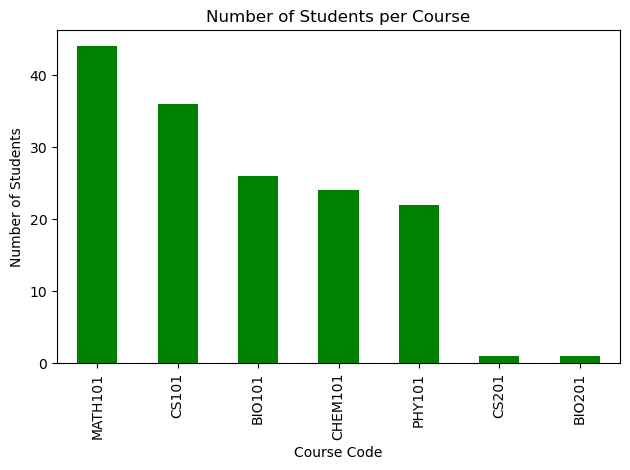


Hello, Admin!
The School Enrollment System
    (1) Add maximum units for a student
    (2) Get Professor Roster
    (3) Get Course Summary - Count of students per Course
    (4) Get Department Summary - Count of students per Department
    (5) Get Enrollee Summary - Count of students per Enrollment Status
    (6) Exit


How can I help you today?  4


Generating chart for students per department...


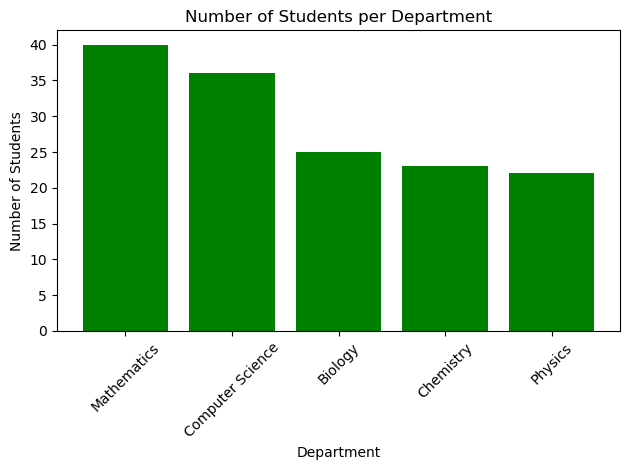


Hello, Admin!
The School Enrollment System
    (1) Add maximum units for a student
    (2) Get Professor Roster
    (3) Get Course Summary - Count of students per Course
    (4) Get Department Summary - Count of students per Department
    (5) Get Enrollee Summary - Count of students per Enrollment Status
    (6) Exit


How can I help you today?  5


Generating chart for students per enrollment status...


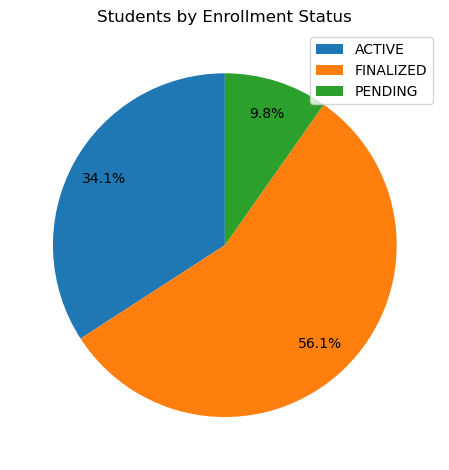


Hello, Admin!
The School Enrollment System
    (1) Add maximum units for a student
    (2) Get Professor Roster
    (3) Get Course Summary - Count of students per Course
    (4) Get Department Summary - Count of students per Department
    (5) Get Enrollee Summary - Count of students per Enrollment Status
    (6) Exit


How can I help you today?  6


Goodbye, Admin!
Welcome, Student!
The School Enrollment System
    (1) Create a System Account
    (2) Enroll a Course
    (3) Remove an Enrollment
    (4) Finalize my Courses
    (5) Get my Timetable
    (6) Exit


How can I help you today?  6


Goodbye, Student!


In [5]:
import sqlite3
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

def student_menu():
    #welcome page for students
    wstud = """The School Enrollment System
    (1) Create a System Account
    (2) Enroll a Course
    (3) Remove an Enrollment
    (4) Finalize my Courses
    (5) Get my Timetable
    (6) Exit"""

    while True:
      try:
        system = EnrollmentSystem()
        print("Welcome, Student!")
        print(wstud)
        ans = int(input("How can I help you today? "))

        #the student wants to create an account
        if ans == 1:
          studnum = input("Please enter your student number (note: 9 characters): ")
               
          #this is where we check for dupes
          if Student.checkdupes(studnum=studnum):
            print("Student Number already exists! Please use a different number.")
            continue
          else:
            print("Student Number is available. Proceeding...")

          fname = input("Please enter your first name (note: 25 characters max): ")
          lname = input("Please enter your last name (note: 25 characters max): ")
          dobstring = input("When is your birthday? Please enter date in YYYY-MM-DD format: ")
          dob = datetime.strptime(dobstring, "%Y-%m-%d").date()
          prog = input("What program are you in? (Please use the program code. ex: BSBIO) ")
          phone = input("Please enter your 11 digit phone number: ")

          #this is where student is init in stdnt class
          studata = Student(studnum, fname, lname, dob, prog, phone)
          stdict = studata.todict([])
          stinput = studata.insertnewstd(stdict)
          print(stinput)
        
        elif ans == 2:
          studnum = input("Please enter your student number (note: 9 characters): ")
            
          #USING CHECKDUPES TO SCREEN STUDENT NUMBERS THAT DO NOT EXIST
          if Student.checkdupes(studnum=studnum):
            print("Student Number exists! Proceeding...")
          else:
            print("Student Number does not exist!")
            continue
          #this is to check enrollment status
          if system.get_enroll_stat(studnum) == 'FINALIZED':
              print("Enrollment already Finalized!")
              continue
          elif system.get_enroll_stat(studnum) == 'PENDING':
              print("Please wait for Admin to set your maximum units allowed.")
              continue
              
          #show course options
          conn = sqlite3.connect('theschool.db')
          cursor = conn.cursor()
        
          cursor.execute("""
              SELECT cs.SECTID, c.CCODE, c.CDESC, cs.SCHEDDAY, cs.SCHEDTIME, cs.STUDCAP, COUNT(e.ID) AS ENROLLED_COUNT
              FROM coursesection cs
              JOIN course c ON cs.CCODE = c.CCODE
              LEFT JOIN enrollment e ON cs.SECTID = e.SECTID
              WHERE c.CCODE NOT IN (
                  SELECT CCODE FROM enrollment WHERE STUDNUM = ?)
              GROUP BY cs.SECTID
              HAVING ENROLLED_COUNT < cs.STUDCAP
          """,(studnum,))
          sections = cursor.fetchall()
          conn.close()

          print("Available Sections:")
          for sec in sections:
            print(f"Section ID: {sec[0]} | {sec[1]}: {sec[2]} | Schedule: {sec[3]} {sec[4]}, Max Students: {sec[5]}")

          secid = input("Please enter the Section ID you want to enroll in: ")
          result = system.enroll_student(studnum, secid)
          print(result)
        
        elif ans == 3:
          studnum = input("Enter your student number: ")
            
          #USING CHECKDUPES TO SCREEN STUDENT NUMBERS THAT DO NOT EXIST
          if Student.checkdupes(studnum=studnum):
            print("Student Number exists! Proceeding...")
          else:
            print("Student Number does not exist!")
            continue

          #this is to check enrollment status
          if system.get_enroll_stat(studnum) == 'FINALIZED':
              print("Enrollment already Finalized!")
              continue

          print(system.get_timetable(studnum))
          secid = input("Enter section ID to remove: ")
          print(system.remove_enroll(studnum, secid))
        
        elif ans == 4:
          studnum = input("Enter your student number: ")
            
          #USING CHECKDUPES TO SCREEN STUDENT NUMBERS THAT DO NOT EXIST
          if Student.checkdupes(studnum=studnum):
            print("Student Number exists! Proceeding...")
          else:
            print("Student Number does not exist!")
            continue
              
          print(system.finalize_student(studnum))

        elif ans == 5:
          studnum = input("Enter your student number: ")
            
          #USING CHECKDUPES TO SCREEN STUDENT NUMBERS THAT DO NOT EXIST
          if Student.checkdupes(studnum=studnum):
            print("Student Number exists! Proceeding...")
          else:
            print("Student Number does not exist!")
            continue
              
          print(system.get_timetable(studnum))
        
        elif ans == 6:
          print("Goodbye, Student!")
          break

        elif ans == 7:
          system2 = AdminSystem()
          admin_menu()

        else:
          print("Wrong choice. Please enter a number.")
          continue

      except ValueError:
        print("Wrong choice. Please enter a number.")
        continue

system = EnrollmentSystem()
student_menu()
               